In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-03-17 11:13:13.797498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 11:13:13.797529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [3]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

In [4]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
adata = adata[adata.obs.treatment != 'nan']

## IFNg marker genes

In [5]:
adata.obs['treatment_infection'] = adata.obs.treatment.astype(str) + '_' + adata.obs.infected.astype(str)

Trying to set attribute `.obs` of view, copying.


In [6]:
groups = ['mock_True', 'IFNg_False', 'IFNg_True']
sc.tl.rank_genes_groups(adata, groupby='treatment_infection', groups=groups, reference='mock_False')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_infection' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/iolib/foreign.py:651: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

Write to csv to send to Lukas.

In [7]:
dfs = []
for group in groups:
    df = sc.get.rank_genes_groups_df(adata, group='mock_True')
    df['condition'] = group
    dfs.append(df)

In [8]:
pd.concat(dfs).to_csv('2022-03_IFNg_marker_genes_scanpy.csv')

## IFNg according to a model

In [43]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
%%time
clf = LogisticRegression(solver='saga')

subset = adata[(adata.obs.treatment.isin(['mock', 'IFNg'])) & (adata.obs.infected == 'False')]  # should also include the overlap of the genes in Lukas' dataset
clf.fit(subset.X.toarray(), subset.obs.treatment.values)

CPU times: user 6min 45s, sys: 5.27 s, total: 6min 50s
Wall time: 6min 51s


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(solver='saga')

In [59]:
adata.obs['IFNg_pred'] = clf.predict_proba(adata.X.toarray())

(0.0, 1.0)

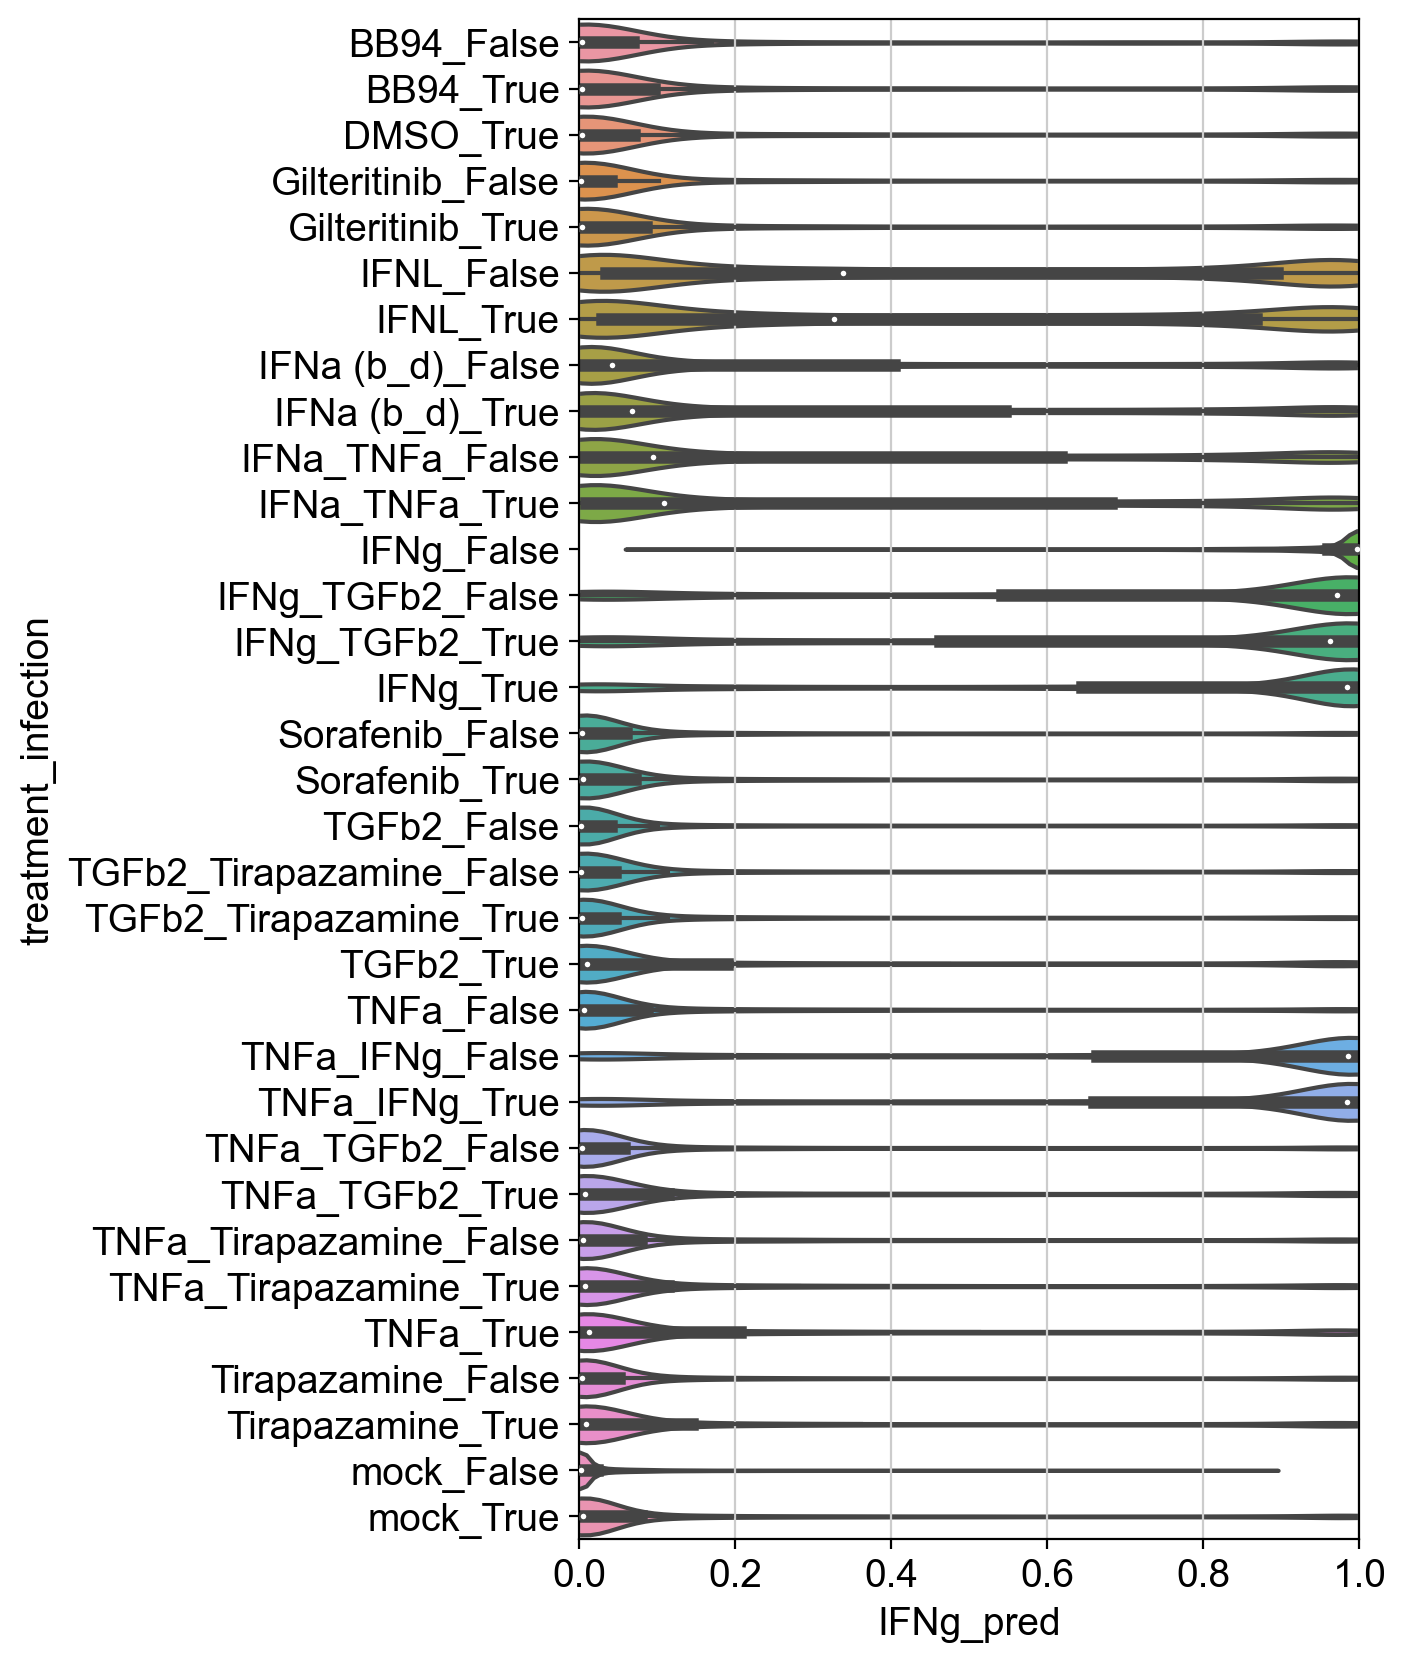

In [60]:
plt.figure(figsize=(5, 10))
sns.violinplot(data=adata.obs, x='IFNg_pred', y='treatment_infection', scale='width')
plt.xlim(0, 1)

We see that the model successfully scores IFNg signatures in treatments with IFNg, and otherwise not. The size of the probability distribution only maybe reflects the size of the similarity to IFNg, so it might very well be not good on another dataset due to batch effect but one can hope/think.

## IFNg markers genes according diffxpy (does not work)

I'm fairly certain it's possible to decompose the effect using a model in diffxpy, but I can't figure out how...

In [11]:
import diffxpy.api as de

In [14]:
test = de.test.pairwise(
    data=adata,
    grouping='treatment',
    test="t-test",
    lazy=False,
    noise_model=None
)

/home/icb/yuge.ji/diffxpy/diffxpy/testing/det.py:1567: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_x0 = np.asarray(np.mean(x0, axis=0)).flatten().astype(dtype=np.float)


In [24]:
test.summary()  # ??? nothing??